# Livneh Average Tmin

In [1]:
# imports
import numpy
import Nio
import Ngl
from IPython import display
import netCDF4 as nc
from datetime import date
from datetime import timedelta
import xarray as xr
import xesmf as xe

In [2]:
# reading in livneh
fn = '/cw3e/mead/projects/cwp103/scratch/ldehaan/Livneh/ptt_2017.nc'
liv = xr.open_dataset(fn)
liv['Tmax'][35:46]

<xarray.DataArray 'Tmax' (Time: 11, lat: 444, lon: 922)>
[4503048 values with dtype=float32]
Coordinates:
  * Time     (Time) datetime64[ns] 2017-02-05 2017-02-06 ... 2017-02-15
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03
Attributes:
    units:    Celsius

In [3]:
# averaging
sum_arr = liv['Tmin'][35].data
for i in numpy.arange(36, 46): # before time shift 36, 46
    sum_arr += liv['Tmin'][i].data
avg = sum_arr / 11 #13

# for reference
numpy.unique(avg), numpy.unique(sum_arr)

(array([-28.717756, -28.285383, -28.135376, ...,        nan,        nan,
               nan], dtype=float32),
 array([-315.89532, -311.13922, -309.48914, ...,        nan,        nan,
               nan], dtype=float32))

In [4]:
# janky way to find average using wrf coords, subtracting livneh avg/pt by random 
# wrf to create nans then adding livneh avg/pt back so we can remove pts not in common
wrf_05 = xr.open_dataset('./wrf_05.nc')
wf = wrf_05['maxes'].data
wf[wf == 0.0] = 'nan'
sub = numpy.subtract(avg, wf)
avg2 = numpy.add(wf, sub)
numpy.unique(wf), numpy.unique(sub), numpy.unique(avg2)

(array([250.81540799, 250.99483643, 251.26210883, ...,          nan,
                 nan,          nan]),
 array([-299.07839777, -298.83027745, -298.51068567, ...,           nan,
                  nan,           nan]),
 array([-24.97049522, -24.53056717, -24.33524132, ...,          nan,
                 nan,          nan]))

In [5]:
# convert dif_arr to masked array to overlook NaNs
import numpy.ma as ma
m_out = ma.masked_invalid(avg2)
m_out

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [6]:
# numerical avg stat over entire region
numpy.mean(m_out.flatten()), min(numpy.unique(m_out)), max(numpy.unique(m_out))

(-4.7105479315137275, -24.970495223999023, 14.763495445251465)

In [7]:
# borrow RHS plot end coords
fn = '/cw3e/mead/projects/cwp103/production/output/2017020500/cf/NG-GR-NQ-BD/wrfcf_d02_2017-02-05_22_00_00.nc'
da_input = xr.open_dataset(fn)

In [8]:
wks_type2 = "png"
wks2 = Ngl.open_wks(wks_type2,"17_livneh_avg_min")

In [9]:
# defining variables
temp = m_out
lat = liv['lat'].data.flatten()
lon = liv['lon'].data.flatten()
lat2 = da_input['lat'].data.flatten()
lon2 = da_input['lon'].data.flatten()
tmax_nlat = len(lat)
tmax_nlon = len(lon)

In [10]:
# XY of overlay plot
resources = Ngl.Resources()
resources.sfXCStartV = min(lon)
resources.sfXCEndV   = max(lon)
resources.sfYCStartV = min(lat)
resources.sfYCEndV   = max(lat)

# fill missing values as needed
if hasattr(temp,"_FillValue"):
    resources.sfMissingValueV = temp._FillValue

# plot styling
resources.cnLevelSelectionMode = "ManualLevels"
resources.cnMinLevelValF       = -20
resources.cnMaxLevelValF       = 32
resources.cnLevelSpacingF      = 4
resources.tiXAxisString = "~F25~Longitude"
resources.tiYAxisString = "~F25~Latitude"
resources.cnFillOn              = True    
resources.cnLineLabelsOn        = False  
resources.cnInfoLabelOn         = False  
resources.nglSpreadColorEnd     = -2
resources.mpProjection = "LambertEqualArea" 
resources.mpCenterLonF = (lon[tmax_nlon-1] + lon[0])/2
resources.mpCenterLatF = (lat[tmax_nlat-1] + lat[0])/2
resources.mpLimitMode = "LatLon"
resources.mpMinLonF   = min(lon2)
resources.mpMaxLonF   = max(lon2)
resources.mpMinLatF   = min(lat2)
resources.mpMaxLatF   = max(lat2)
resources.mpPerimOn   = True
resources.cnLinesOn   = False
resources.mpOutlineBoundarySets = "GeophysicalAndUSStates"
resources.pmTickMarkDisplayMode = "Never"
resources.tiMainString = "~F26~Livneh Tmin Average, 2017-02"
resources.lbOrientation  = "Horizontal"
resources.lbTitleString  = "~F25~Max Temp (C)"

In [11]:
# plot
map = Ngl.contour_map(wks2,temp,resources)

In [12]:
# clean up
del map
del resources
Ngl.end()

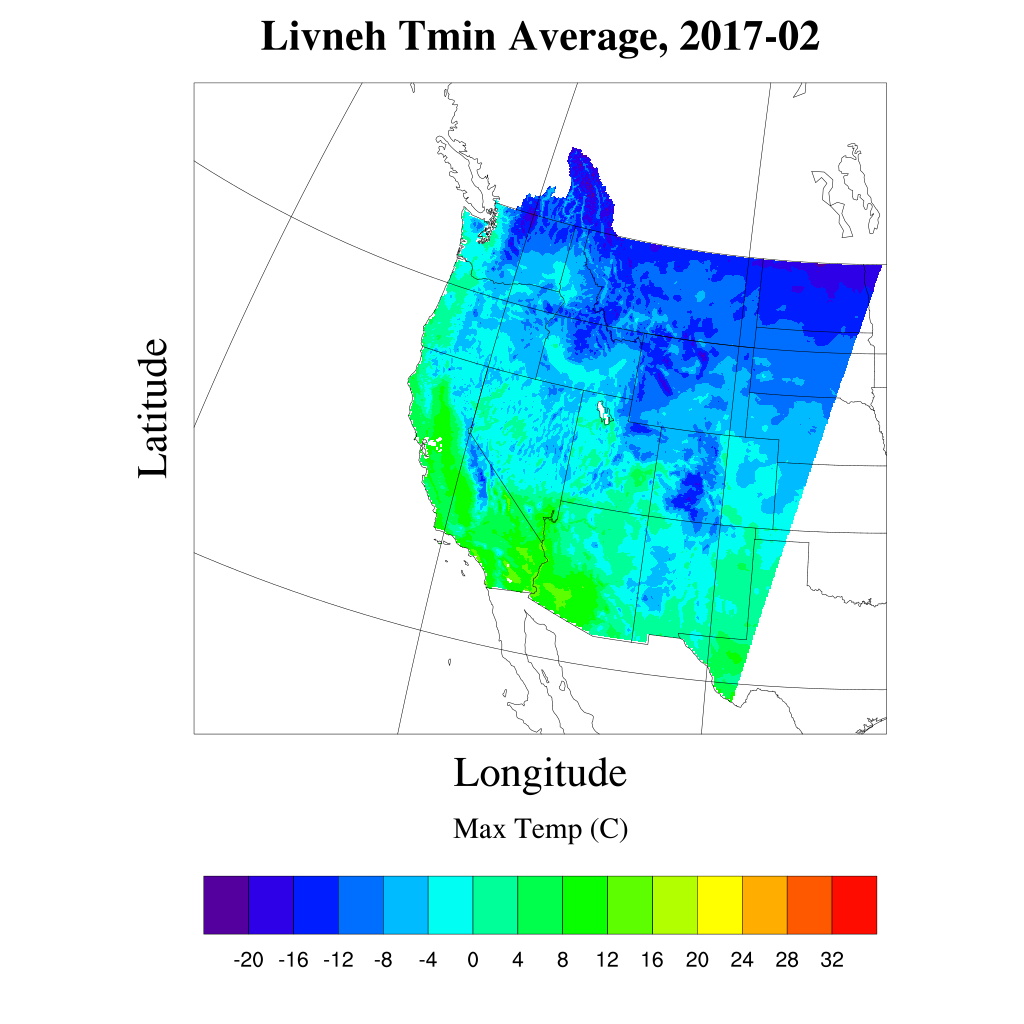

In [13]:
# display plot
display.Image("./17_livneh_avg_min.png")